In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm, pearsonr

import os
import time
import itertools

from glove_VI.glv3 import *

/home/jcthompson5@ad.wisc.edu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# import file names
files = os.listdir("data/SET3_Thirdtrial/")
files

['CDanc_CDmono12h_PROVIDET0.csv', 'CDevo_CDmono12h_PROVIDET0.csv']

# fit gLV models

Number of parameters: 240
Updating posterior...
Epoch 0, ELBO: -75341.430, Slope: 1.000
encountered 0 nans
Epoch 10, ELBO: -26128.947, Slope: 1.000
encountered 665 nans
Epoch 20, ELBO: -10094.976, Slope: 0.433
encountered 120 nans
Epoch 30, ELBO: 1284.854, Slope: 0.326
encountered 0 nans
Epoch 40, ELBO: 7872.304, Slope: 0.257
encountered 2 nans
Epoch 50, ELBO: 9045.964, Slope: 0.203
encountered 1 nans
Epoch 60, ELBO: 9638.416, Slope: 0.163
encountered 2 nans
Epoch 70, ELBO: 12958.189, Slope: 0.136
encountered 0 nans
Epoch 80, ELBO: 14007.808, Slope: 0.115
encountered 0 nans
Epoch 90, ELBO: 14187.569, Slope: 0.099
encountered 0 nans
Epoch 100, ELBO: 14388.696, Slope: 0.142
encountered 0 nans
Epoch 110, ELBO: 14534.274, Slope: 0.151
encountered 0 nans
Epoch 120, ELBO: 14627.838, Slope: 0.086
encountered 0 nans
Epoch 130, ELBO: 14598.625, Slope: 0.053
encountered 0 nans
Epoch 140, ELBO: 14751.869, Slope: 0.040
encountered 0 nans
Epoch 150, ELBO: 14761.964, Slope: 0.026
encountered 1 nans


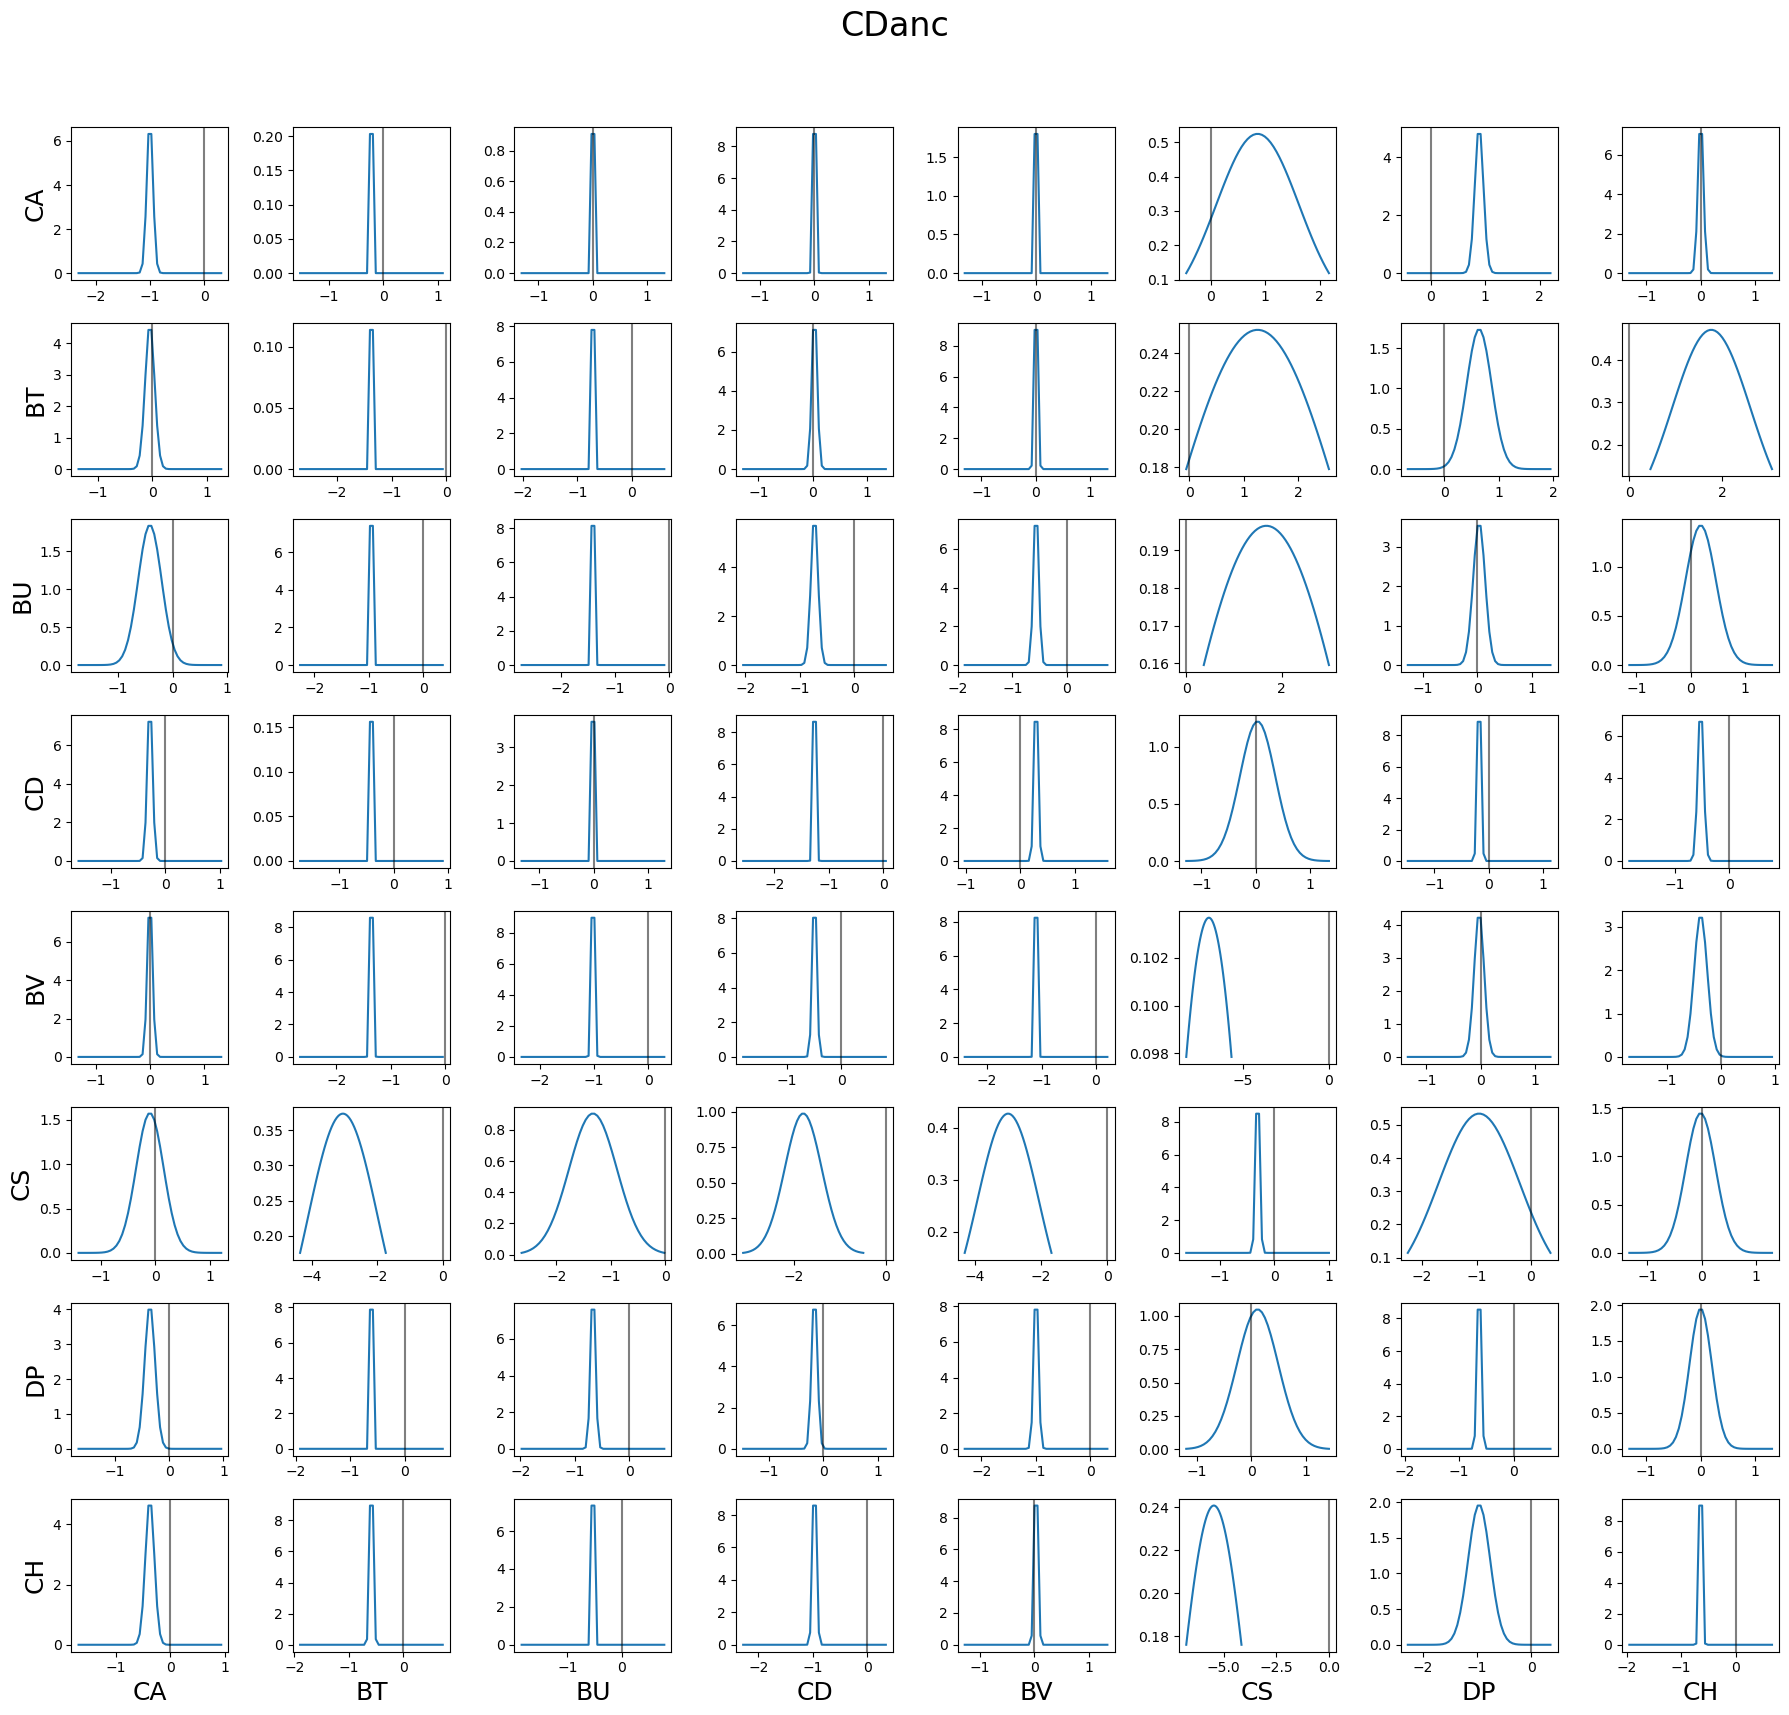

Number of parameters: 240
Updating posterior...
Epoch 0, ELBO: -73448.094, Slope: 1.000
encountered 0 nans
Epoch 10, ELBO: -27034.230, Slope: 1.000
encountered 379 nans
Epoch 20, ELBO: -19048.945, Slope: 0.370
encountered 137 nans
Epoch 30, ELBO: -4703.941, Slope: 0.292
encountered 32 nans
Epoch 40, ELBO: -245.763, Slope: 0.230
encountered 15 nans
Epoch 50, ELBO: 3767.525, Slope: 0.187
encountered 1 nans
Epoch 60, ELBO: 10386.838, Slope: 0.161
encountered 2 nans
Epoch 70, ELBO: 10944.887, Slope: 0.138
encountered 0 nans
Epoch 80, ELBO: 11121.302, Slope: 0.118
encountered 0 nans
Epoch 90, ELBO: 11418.800, Slope: 0.102
encountered 0 nans
Epoch 100, ELBO: 11608.763, Slope: 0.153
encountered 0 nans
Epoch 110, ELBO: 11728.982, Slope: 0.150
encountered 1 nans
Epoch 120, ELBO: 11896.910, Slope: 0.140
encountered 0 nans
Epoch 130, ELBO: 11951.268, Slope: 0.089
encountered 0 nans
Epoch 140, ELBO: 12070.182, Slope: 0.046
encountered 0 nans
Epoch 150, ELBO: 12134.518, Slope: 0.015
encountered 1 n

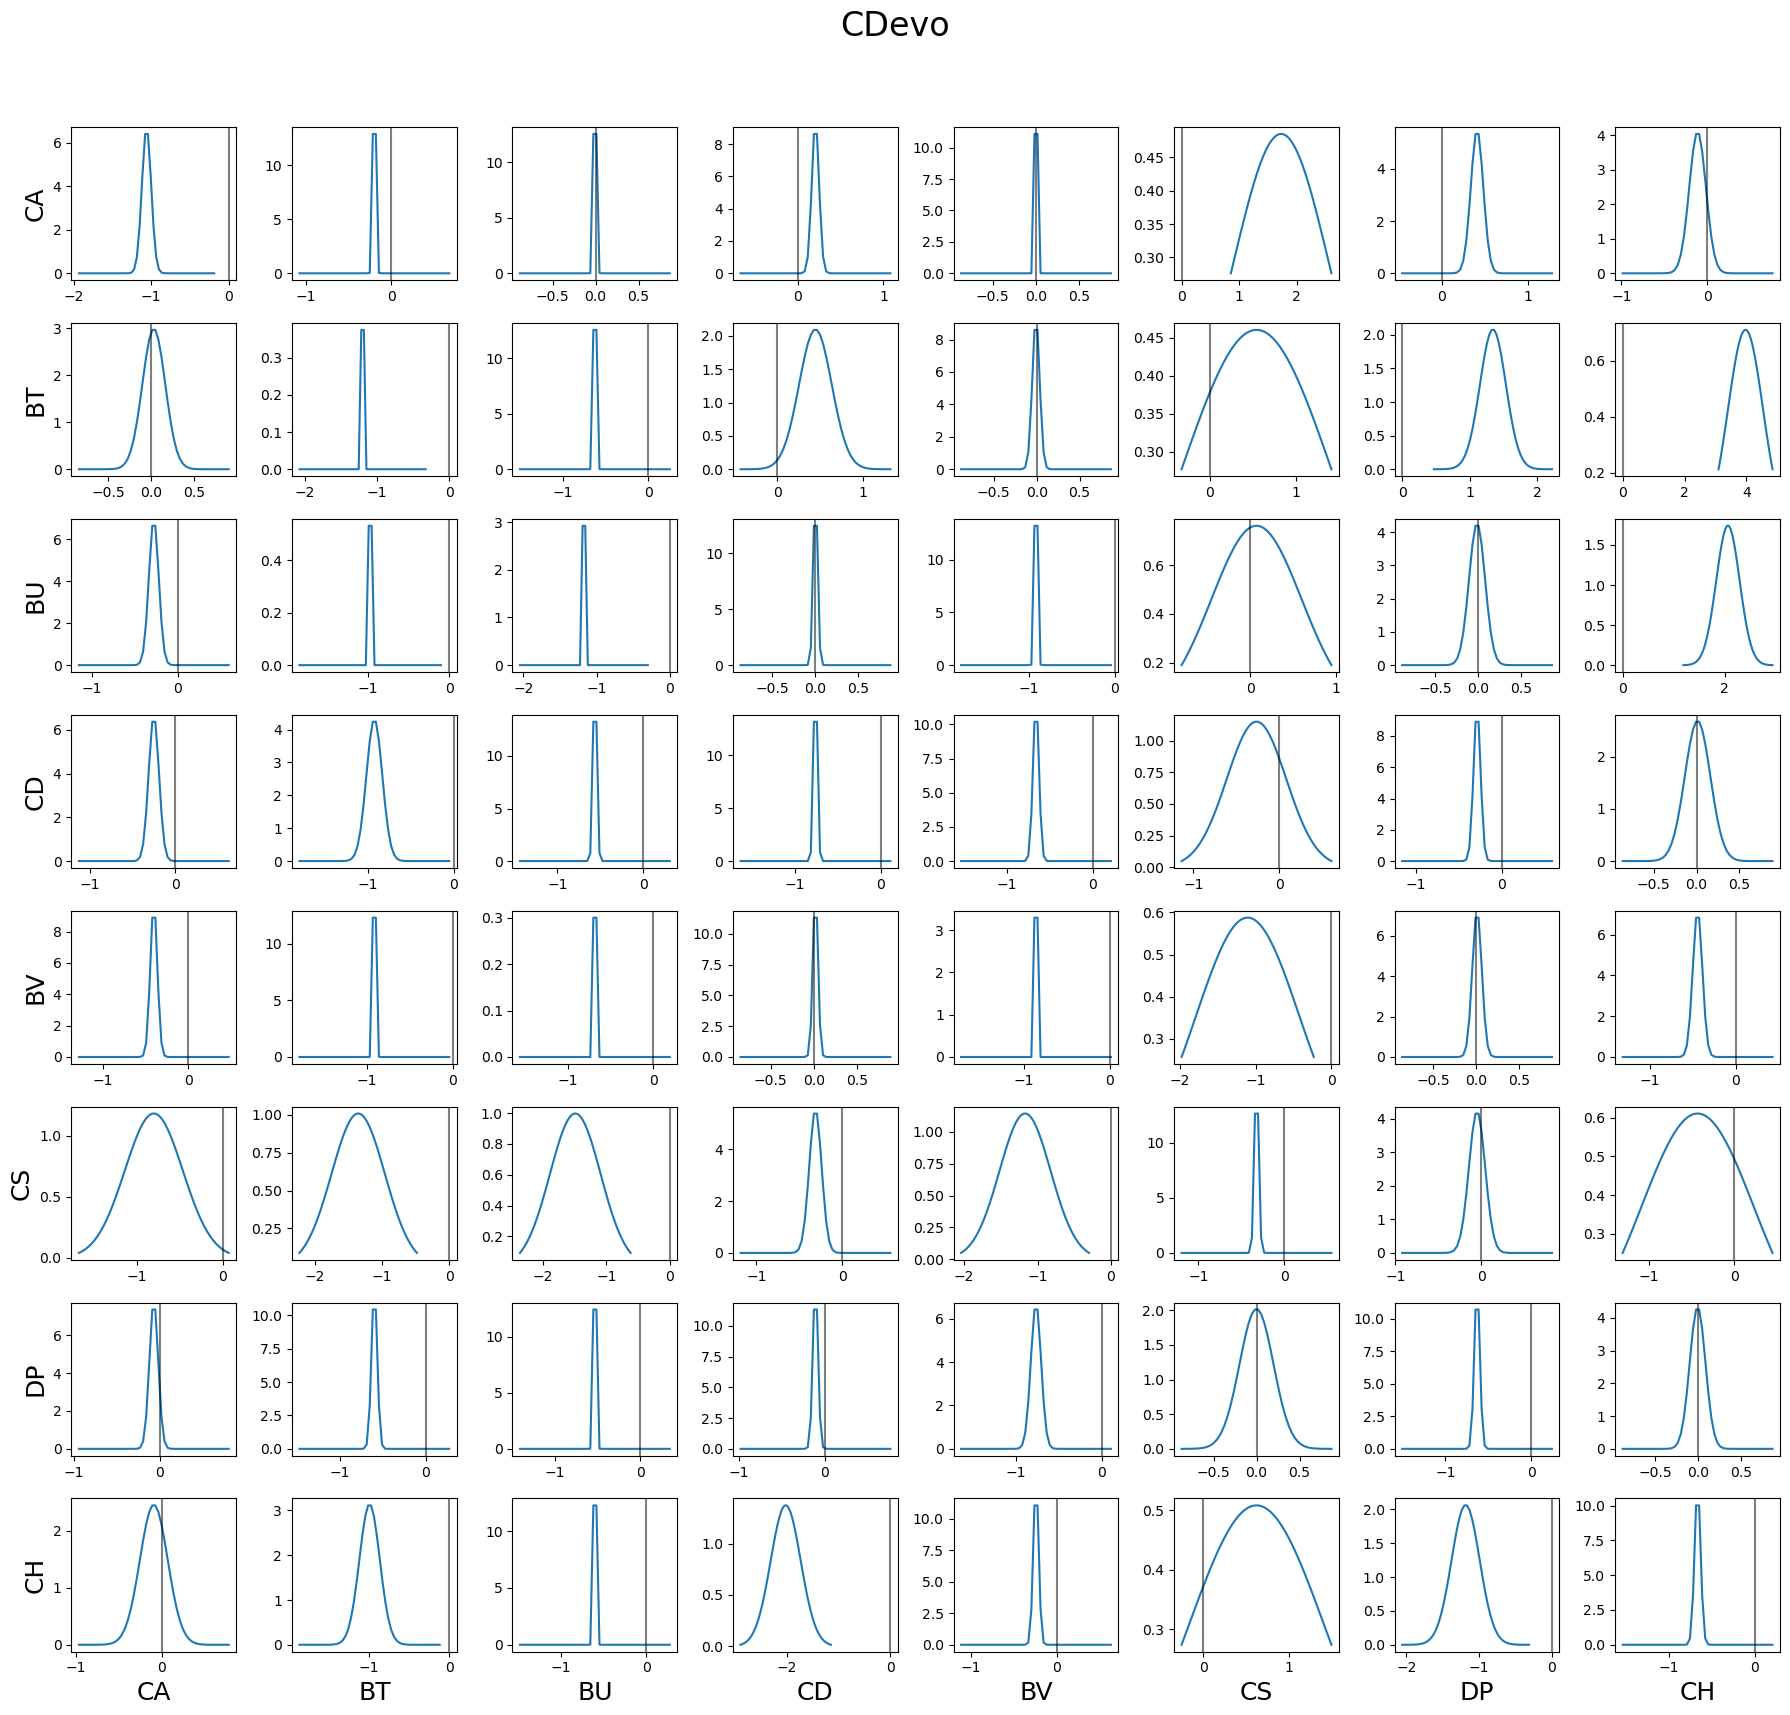

In [3]:
exp_names = []
for file in files:
    
    # define strain name
    strain = file.split("_")[0]

    # import data
    df = pd.read_csv(f"data/SET3_Thirdtrial/{file}")
    df.sort_values(by=["Treatments", "Time"], inplace=True)

    # make sure that conditions have at least one measurement
    dfs = []
    for treatment, df_t in df.groupby("Treatments"):
        if df_t.shape[0] > 1:
            dfs.append(df_t)
    df = pd.concat(dfs)

    # determine species names 
    species = df.columns.values[2:]

    # init model 
    model = gLV(dataframe=df, 
                species=species,
                nu2=.001, sigma2=.01)

    # init params
    model.init_params(sample=False)
    print(f"Number of parameters: {model.n_params}")

    # fit to data 
    model.fit_posterior_EM()

    # plot parameter distribution
    n_species = len(species)
    Avec = model.z[n_species:n_species + n_species**2]
    Aij_std = np.exp(model.lmbda[model.d:])[n_species:n_species + n_species**2]

    plt.figure(figsize=(18,18))
    # set counter for parameter std. 
    k = 0

    for i in range(n_species):
        for j in range(n_species):
            plt.subplot(n_species, n_species, k+1)
            a = np.linspace(Avec[k]-np.std(Avec), Avec[k]+np.std(Avec))
            plt.plot(a, norm.pdf(a,Avec[k],Aij_std[k]))
            plt.axvline(x=0, c='k', alpha=.5)
            k += 1
            if j == 0:
                plt.ylabel(species[i], fontsize=18)
            if i == n_species-1:
                plt.xlabel(species[j], fontsize=18)
            #plt.xlim([-2,2])

    plt.suptitle(strain, fontsize=24)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig("params/SET3/"+strain+"_3.pdf")
    plt.show()

    # list of parameter names 
    param_names2 = []
    for s1 in species:
        for s2 in species:
            param_names2 += [s1+"*"+s2]

    param_names3 = []
    for i,s1 in enumerate(species):
        for j,s2 in enumerate(species):
            if j != i:
                for k,s3 in enumerate(species):
                    if k > j and k !=i:
                        param_names3 += [s1+"*"+s2+"*"+s3]

    param_names = list(species) + param_names2 + param_names3

    # compute Wald test for each parameter
    std_errors = np.exp(model.lmbda[model.d:])
    walds = model.z/std_errors
    wald_p_vals = 2*norm.cdf(-np.abs(walds))

    # save to df 
    df = pd.DataFrame()
    df["Param name"] = param_names
    df["Param value"] = model.z
    df["Param stdv"]  = std_errors
    df["Param p-value"] = wald_p_vals
    df.to_csv("params/SET3/"+strain+"_3_VI.csv", index=False)